### Proseminar: Humanoide Roboter
**Gruppe 3: Object Detection**

# Convolutional Neural Network (CNN)


In [1]:
!pip3 install -q tensorflow-gpu==1.15.3

     |████████████████████████████████| 411.0MB 42kB/s 
     |████████████████████████████████| 512kB 40.8MB/s 
     |████████████████████████████████| 3.8MB 42.3MB/s 
ERROR: tensorflow 2.2.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement tensorflow-estimator<2.3.0,>=2.2.0, but you'll have tensorflow-estimator 1.15.1 which is incompatible.
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.


In [2]:
import os
import sys
import time
from datetime import datetime

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.python.keras import models, optimizers, losses, activations
from tensorflow.python.keras.layers import *
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array

Using TensorFlow backend.


In [3]:
print("Tensorflow Version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Tensorflow Version: 1.15.3
Num GPUs Available:  1


## Parameter

In [0]:
#@title Prepare Parameter


#@markdown #### Prepare Data

FORCE = False #@param {type:"boolean"}

VALIDATION_SPLIT = 0.2 #@param {type:"number"}

IMAGE_FOLDER_NAME = "robot_ball_dataset" #@param {type:"string"}

TEST_FOLDER_NAME = "test_dataset" #@param {type:"string"}

DIMEN = 240 #@param {type:"integer"}

BATCH_SIZE = 64 #@param {type:"integer"}

#@markdown ---

#@markdown #### Load Data

DATA_FOLDER_PATH = "processed_data" #@param {type:"string"}

#@markdown ---

#@markdown #### Prepare Tensorflow Parameter

NUMBER_OF_CLASSES = 2 #@param {type:"integer"}
EPOCHS =  20 #@param {type:"integer"}
DROPOUT_RATE = 0.25 #@param {type:"number"}

MODEL_PATH = "models" #@param {type:"string"}

## Prepare Data

### Download Data from HU Box

In [5]:
# Download image dataset from HU Box

if FORCE or not os.path.exists(IMAGE_FOLDER_NAME):
    print('download robot ball dataset')
    !rm *.zip
    !wget -q --content-disposition "https://box.hu-berlin.de/f/418aae72be444e399a24/?dl=1"
    !unzip -q -o robot_ball_dataset.zip

if FORCE or not os.path.exists(TEST_FOLDER_NAME):
    print('download test dataset')
    !rm *.zip
    !wget -q --content-disposition "https://box.hu-berlin.de/f/4deb5b393e39455b8451/?dl=1"
    !unzip -q -o test_dataset.zip

if not os.path.exists(MODEL_PATH):
    !mkdir models/

!ls -l

download files
rm: cannot remove '*.zip': No such file or directory
download test dataset
total 56608
drwxr-xr-x 2 root root     4096 Jun 11 15:46 models
drwxr-xr-x 4 root root     4096 Jun 11  2020 robot_ball_dataset
drwxr-xr-x 1 root root     4096 May 29 18:19 sample_data
drwxr-xr-x 4 root root     4096 Jun 11  2020 test_dataset
-rw-r--r-- 1 root root 57947279 Jun 11 15:45 test_dataset.zip


### Process Images

In [6]:
train_datagen = ImageDataGenerator(
    rescale = 1. / 255, 
    validation_split = VALIDATION_SPLIT
)

print("train dataset:")
train_generator = train_datagen.flow_from_directory( 
    IMAGE_FOLDER_NAME, 
    target_size = (DIMEN, DIMEN), 
    batch_size = BATCH_SIZE, 
    class_mode = 'binary',
    subset = 'training'
)

print("validation dataset:")
validation_generator = train_datagen.flow_from_directory( 
    IMAGE_FOLDER_NAME, 
    target_size = (DIMEN, DIMEN), 
    batch_size = BATCH_SIZE, 
    class_mode = 'binary',
    subset = 'validation'
)

print("test dataset:")
test_generator = train_datagen.flow_from_directory( 
    TEST_FOLDER_NAME, 
    target_size = (DIMEN, DIMEN), 
    batch_size = BATCH_SIZE, 
    class_mode = 'binary',
)

train dataset:
Found 16209 images belonging to 2 classes.
validation dataset:
Found 4052 images belonging to 2 classes.
test dataset:
Found 5064 images belonging to 2 classes.


### Verify Data

first batch:


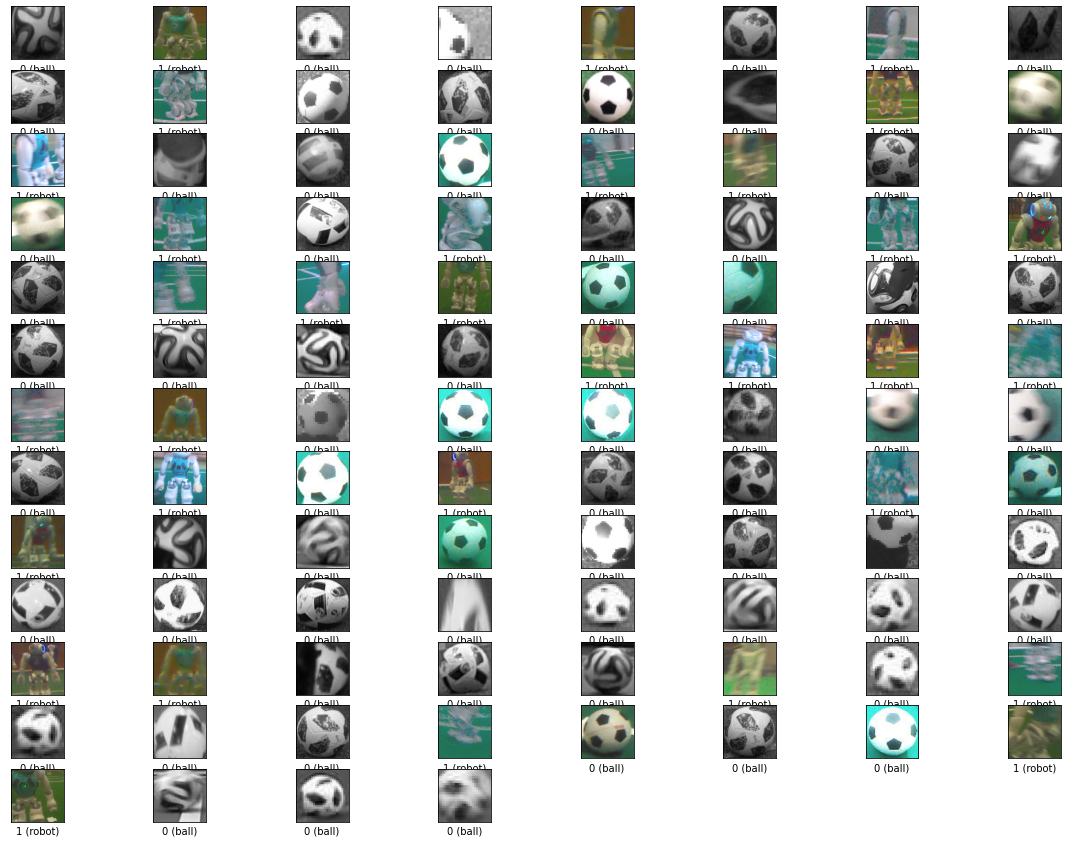

In [7]:
print('first batch:')
x,y = train_generator.next()

# kann vermutlich auch woanders her gelesen werden?

class_names = np.sort(next(os.walk(IMAGE_FOLDER_NAME))[1])
h_grid_size = 8

plt.figure(figsize=(20, 15))
for i in range (BATCH_SIZE):
    plt.subplot(BATCH_SIZE // h_grid_size + 1, h_grid_size, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    image = x[i].squeeze()
    plt.imshow(image)

    label = int(y[i])
    plt.xlabel('{} ({})'.format(label, class_names[label]))

plt.show()

## Create neural network

In [8]:
activation_func = activations.relu

NEURAL_SCHEMA = [

    Conv2D(32, (3, 3), activation=activation_func, input_shape=(DIMEN, DIMEN, 3)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation=activation_func),
    MaxPooling2D((2, 2)),

    Flatten(),
    
    Dense(100, activation=activation_func),
    Dropout(DROPOUT_RATE),

    Dense(NUMBER_OF_CLASSES, activation=tf.nn.softmax)
]

model = tf.keras.Sequential(NEURAL_SCHEMA)

model.compile(
    optimizer=optimizers.Adam(),
    loss=losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 238, 238, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 119, 119, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 117, 117, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 58, 58, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 215296)            0         
_________________________________________________________________
dense (Dense)                (None, 100)               21529700  
_________________________________________

## Train Model

In [9]:
initial_time = time.time()

history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // BATCH_SIZE,
)
    
final_time = time.time()
eta = (final_time - initial_time)
time_unit = 'seconds'
if eta >= 60:
    eta = eta / 60
    time_unit = 'minutes'
print('Elapsed time acquired for {} epoch(s) -> {} {}'.format(EPOCHS, eta, time_unit))

model_path = os.path.join(MODEL_PATH, 'model-{}.h5'.format(datetime.fromtimestamp(final_time).strftime("%Y-%m-%d_%H-%M")))
model.save(model_path)

Epoch 1/20
162/162 [==============================] - 64s 394ms/step - loss: 0.2199 - acc: 0.9629 - val_loss: 2.3065e-04 - val_acc: 1.0000
Epoch 2/20
162/162 [==============================] - 55s 340ms/step - loss: 0.0245 - acc: 0.9924 - val_loss: 0.0070 - val_acc: 0.9983
Epoch 3/20
162/162 [==============================] - 55s 340ms/step - loss: 0.0107 - acc: 0.9971 - val_loss: 5.6033e-04 - val_acc: 0.9998
Epoch 4/20
162/162 [==============================] - 55s 340ms/step - loss: 0.0154 - acc: 0.9951 - val_loss: 7.7789e-04 - val_acc: 0.9998
Epoch 5/20
162/162 [==============================] - 55s 340ms/step - loss: 0.0083 - acc: 0.9976 - val_loss: 0.0048 - val_acc: 0.9995
Epoch 6/20
162/162 [==============================] - 55s 341ms/step - loss: 0.0050 - acc: 0.9984 - val_loss: 3.9658e-04 - val_acc: 0.9998
Epoch 7/20
162/162 [==============================] - 55s 341ms/step - loss: 0.0102 - acc: 0.9964 - val_loss: 0.0101 - val_acc: 0.9950
Epoch 8/20
162/162 [===================

## Evaluate Model

51/51 - 7s - loss: 1.0712e-04 - acc: 1.0000
test_acc: 1.0


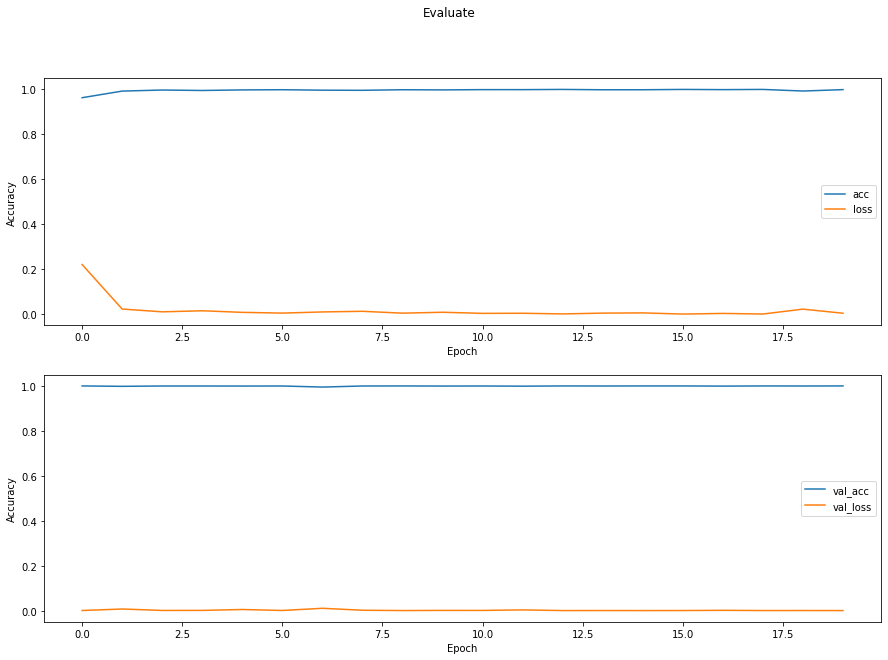

In [41]:
fig, (ax1, ax2)= plt.subplots(nrows=2, ncols=1, figsize=(15,10))

fig.suptitle('Evaluate')

ax1.plot(history.history['acc'], label='acc')
ax1.plot(history.history['loss'], label='loss')

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='center right')

ax2.plot(history.history['val_acc'], label = 'val_acc')
ax2.plot(history.history['val_loss'], label='val_loss')

ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='center right')

test_loss, test_acc = model.evaluate_generator(test_generator, verbose=2)
print('test_acc: {}'.format(test_acc))

## Predict

51/51 - 7s - loss: 1.0716e-04 - acc: 1.0000
test_acc: 1.0
